--
title: Exploring modeling failure
mathjax: True
--

> In [my last post](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/), I gave an example of a multilevel model using a binomial generalized linear model (GLM). The varying intercept model helped illustrate partial pooling, shrinkage, and information sharing. The equation to create the mixed effects model was simple. But how exactly is "information shared"? Let's get started!

This is how I was going to start this post. I thought this would be a fairly quick write-up where I would simplify the dataset by showing a few visualizations to demonstrate some concepts. But during this process, I realized the act of simplifying my dataset (using only three clusters) caused divergences when trying to obtain the posterior distribution. This is something that Richard McElreath had warned readers about on pages 407 and 408 of Statistical Rethinking. I tested and adjusted my priors--hard and unglamorous work that I planned to minimize to not distract from the main lesson.

However, I listened to [Alex Andorra's conversation with Michael Betancourt in the Learning Bayesian Statistics podcast #6](https://www.learnbayesstats.com/episodes/9#showEpisodes). Around the 30 min mark, Alex and Michael talk about how failure is necessary for learning. Remarkably (for me), a few minutes later Michael uses the example specific to heirarchical models and about how problems can come from interactions between population location and population scale, including when there are only a small number of groups.

Instead of glossing over my observation, let's dive into the problem, explore the model failure, and see how adjustments to priors and the modeling equations can resolve it.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
from theano import tensor as tt

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

I'll be re-using the problem described in the [last post](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/#problem-description), so I won't re-write everything. But let's show the fixed effects and mixed effects models from the original post since we'll be contrasting them.

**Equation for fixed effects model**

Model `mfe` equation

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(0, 1.5) \tag{regularizing prior}$$

**Equation for mixed effects model**

Model `mme` equation

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{Exponential}(1) \tag{regularizing hyperprior}$$

The main difference is the use of an adaptive prior and the regularizing hyperiors in the mixed effects equations. There will be another change to the $\sigma$ term of the mixed effects model which I'll detail later.

# Data exploration and setup

I'll load and clean all in this one cell and skip the details. Review the last post if you'd like to revisit this step.

In [4]:
df_bangladesh = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/bangladesh.csv",
    delimiter=";",
)
# Fix the district variable
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes

<IPython.core.display.Javascript object>

To make the lessons of multi-level model more comprehensible, let's limit the dataframe to only the first three districts. (As you'll see, here is where I encountered trouble.)

In [5]:
df_bangladesh_first3 = df_bangladesh[df_bangladesh["district_code"] < 3].copy()

<IPython.core.display.Javascript object>

 We can also get a count of women represented in each district. The variability in the number of women will help drive some of the lessons home further.

In [6]:
df_bangladesh_first3['district_code'].value_counts()

0    117
1     20
2      2
Name: district_code, dtype: int64

<IPython.core.display.Javascript object>

# Fixed-effects model

In [7]:
with pm.Model() as mfe:

    # alpha prior, one for each district
    a = pm.Normal("a", 0, 1.5, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

Let's do some model diagnostics with some `arviz` functions.

- `az.summary` can provide the effective sample size (like with `ess_mean`) and `r_hat` values. The effective sample size is an indication of how well the posterior distribution was explored by HMC. Since Markov chains are typically autocorrelated, sampling within a chain is not entirely independent. The effective sample size accounts for this correlation. This number can even exceed the raw sample size. The `r_hat` value is "estimated between-chains and within-chain variances for each model parameter" [source](https://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/). (While an imperfect analogy, I think of [ANOVA and the F-test](https://en.wikipedia.org/wiki/Analysis_of_variance) which is calculated as variance between groups divided by variance within groups.) McElreath cautions that an `r_hat` value above 1.00 is a signal of danger, but not of safety; an invalid chain can still reach 1.00.

In [8]:
az.summary(trace_mfe)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0] -1.058  0.211    -1.380     -0.710      0.003    0.002    4574.0  4005.0   
a[1] -0.592  0.439    -1.287      0.086      0.006    0.005    5652.0  3980.0   
a[2]  1.220  1.162    -0.582      3.069      0.015    0.014    5776.0  3345.0   

      ess_bulk  ess_tail  r_hat  
a[0]    4666.0    2322.0    1.0  
a[1]    5674.0    3009.0    1.0  
a[2]    5811.0    2619.0    1.0

<IPython.core.display.Javascript object>

The `az.plot_trace` and `az.plot_rank` functions output visualizations. The former theoretically can be used to assess how well chains are mixing, but it can be hard to see. The latter are histograms of the ranked samples. This tells us how evenly a particular chain's samples come in "ranked" across all samples and chains. Efficient exploration of the posterior should yield uniform distributions in these kind of plots (known as trace rank or "trank" plots).

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

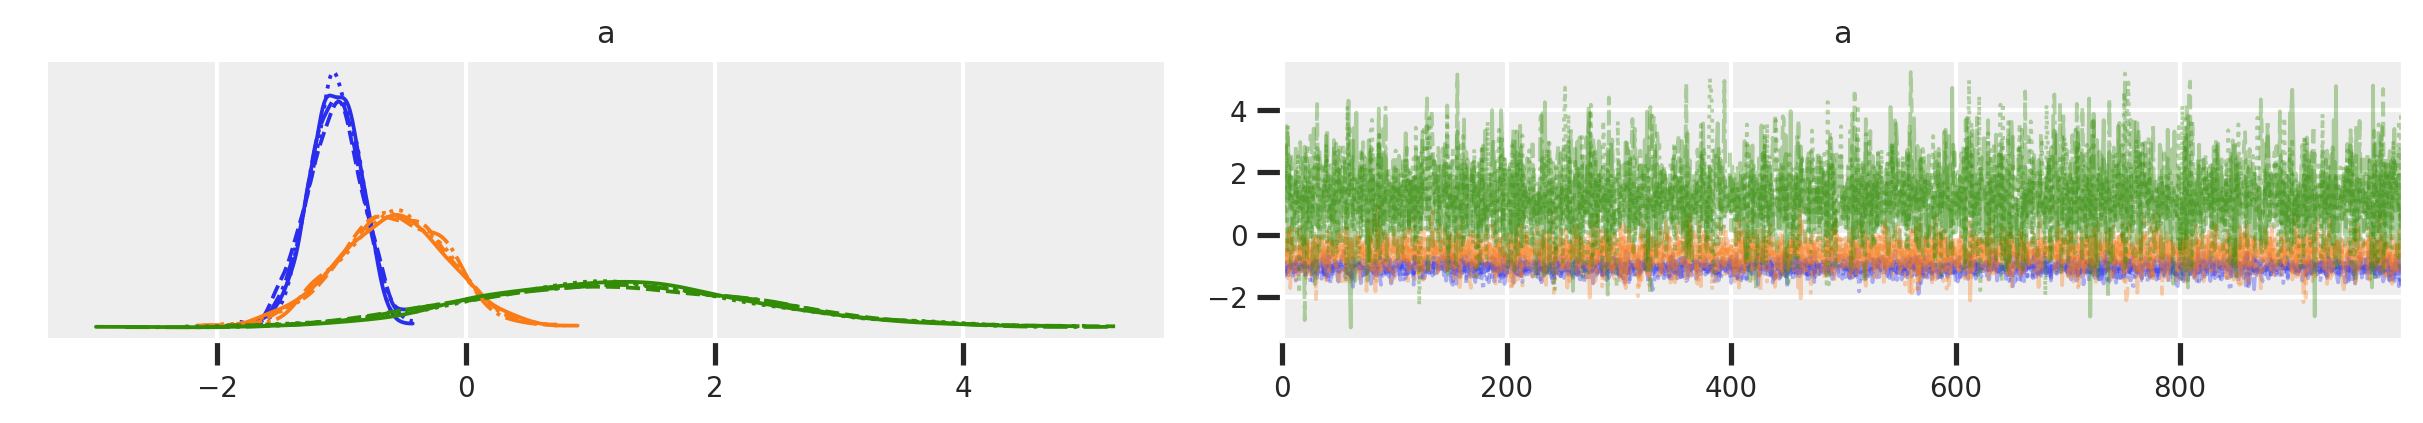

<IPython.core.display.Javascript object>

In [12]:
az.plot_trace(trace_mfe)

array([<AxesSubplot:title={'center':'a\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'a\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'a\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

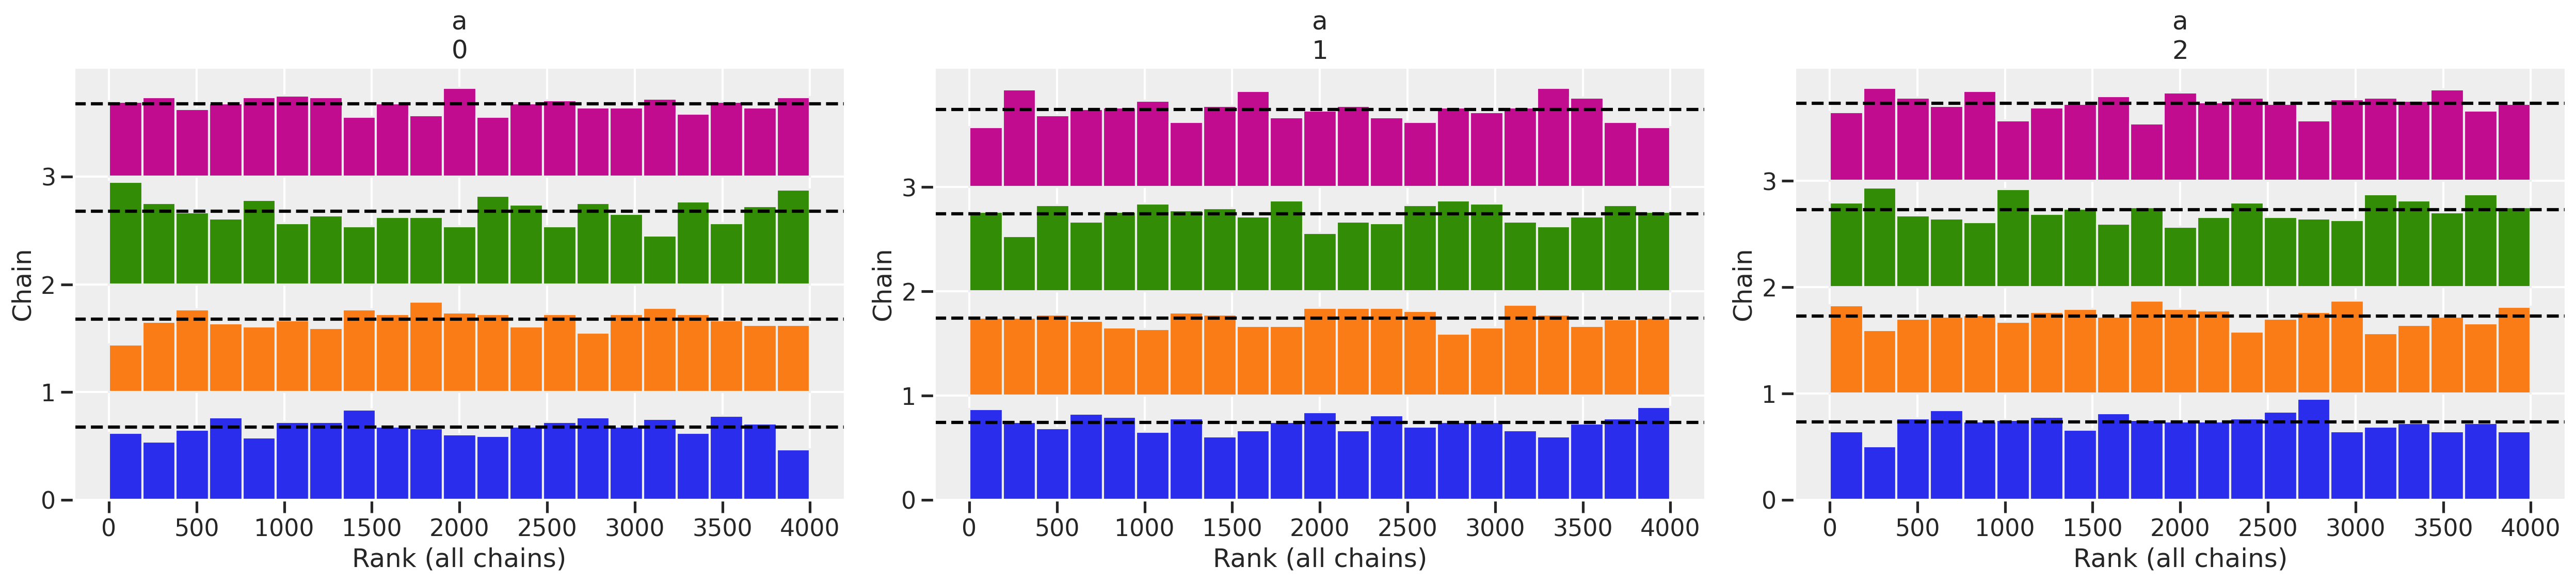

<IPython.core.display.Javascript object>

In [10]:
az.plot_rank(trace_mfe)

As you can see in this case, the model ran great. Some indications for this:
- Pymc gave no warnings about divergences.
- While we would need something to compare it to, the number of samples `ess_mean` is high.
- The `r_hat` is 1.0 which is a sign of "lack of danger".
- The trace plots apparently show good "wiggliness" and inter-mixing between chains is confirmed by the trank plots.

In the plots, the blue chain is `district0`, orange is `district1`, and green is `district2`, but let's not focus too much on interpretation for now. 

Let's see how the first iteration of our mixed effects model looks. We'll paramaterize as we had done in the last post and as the equations show above.

# Mixed-effects (ME) attempt 0

In [13]:
with pm.Model() as mme0:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha prior, we only have 1 district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mme0 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7116085658262987, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

Wow, we've already got a [number of issues](https://media.giphy.com/media/fwbo0KVql262TePTMZ/giphy.gif). Let's take a look at our summary and trace plots.

In [14]:
az.summary(trace_mme0)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar -0.449  0.703    -1.638      0.532      0.024    0.017     874.0   
a[0]  -1.031  0.206    -1.355     -0.712      0.008    0.006     666.0   
a[1]  -0.642  0.434    -1.379     -0.025      0.014    0.011     996.0   
a[2]   0.282  1.358    -1.513      2.137      0.051    0.036     715.0   
sigma  0.966  0.752     0.167      1.885      0.033    0.023     523.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar   874.0     848.0     394.0   1.00  
a[0]    666.0     662.0    1641.0   1.00  
a[1]    821.0     993.0     330.0   1.00  
a[2]    715.0     663.0     382.0   1.00  
sigma   523.0     232.0     134.0   1.01

<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

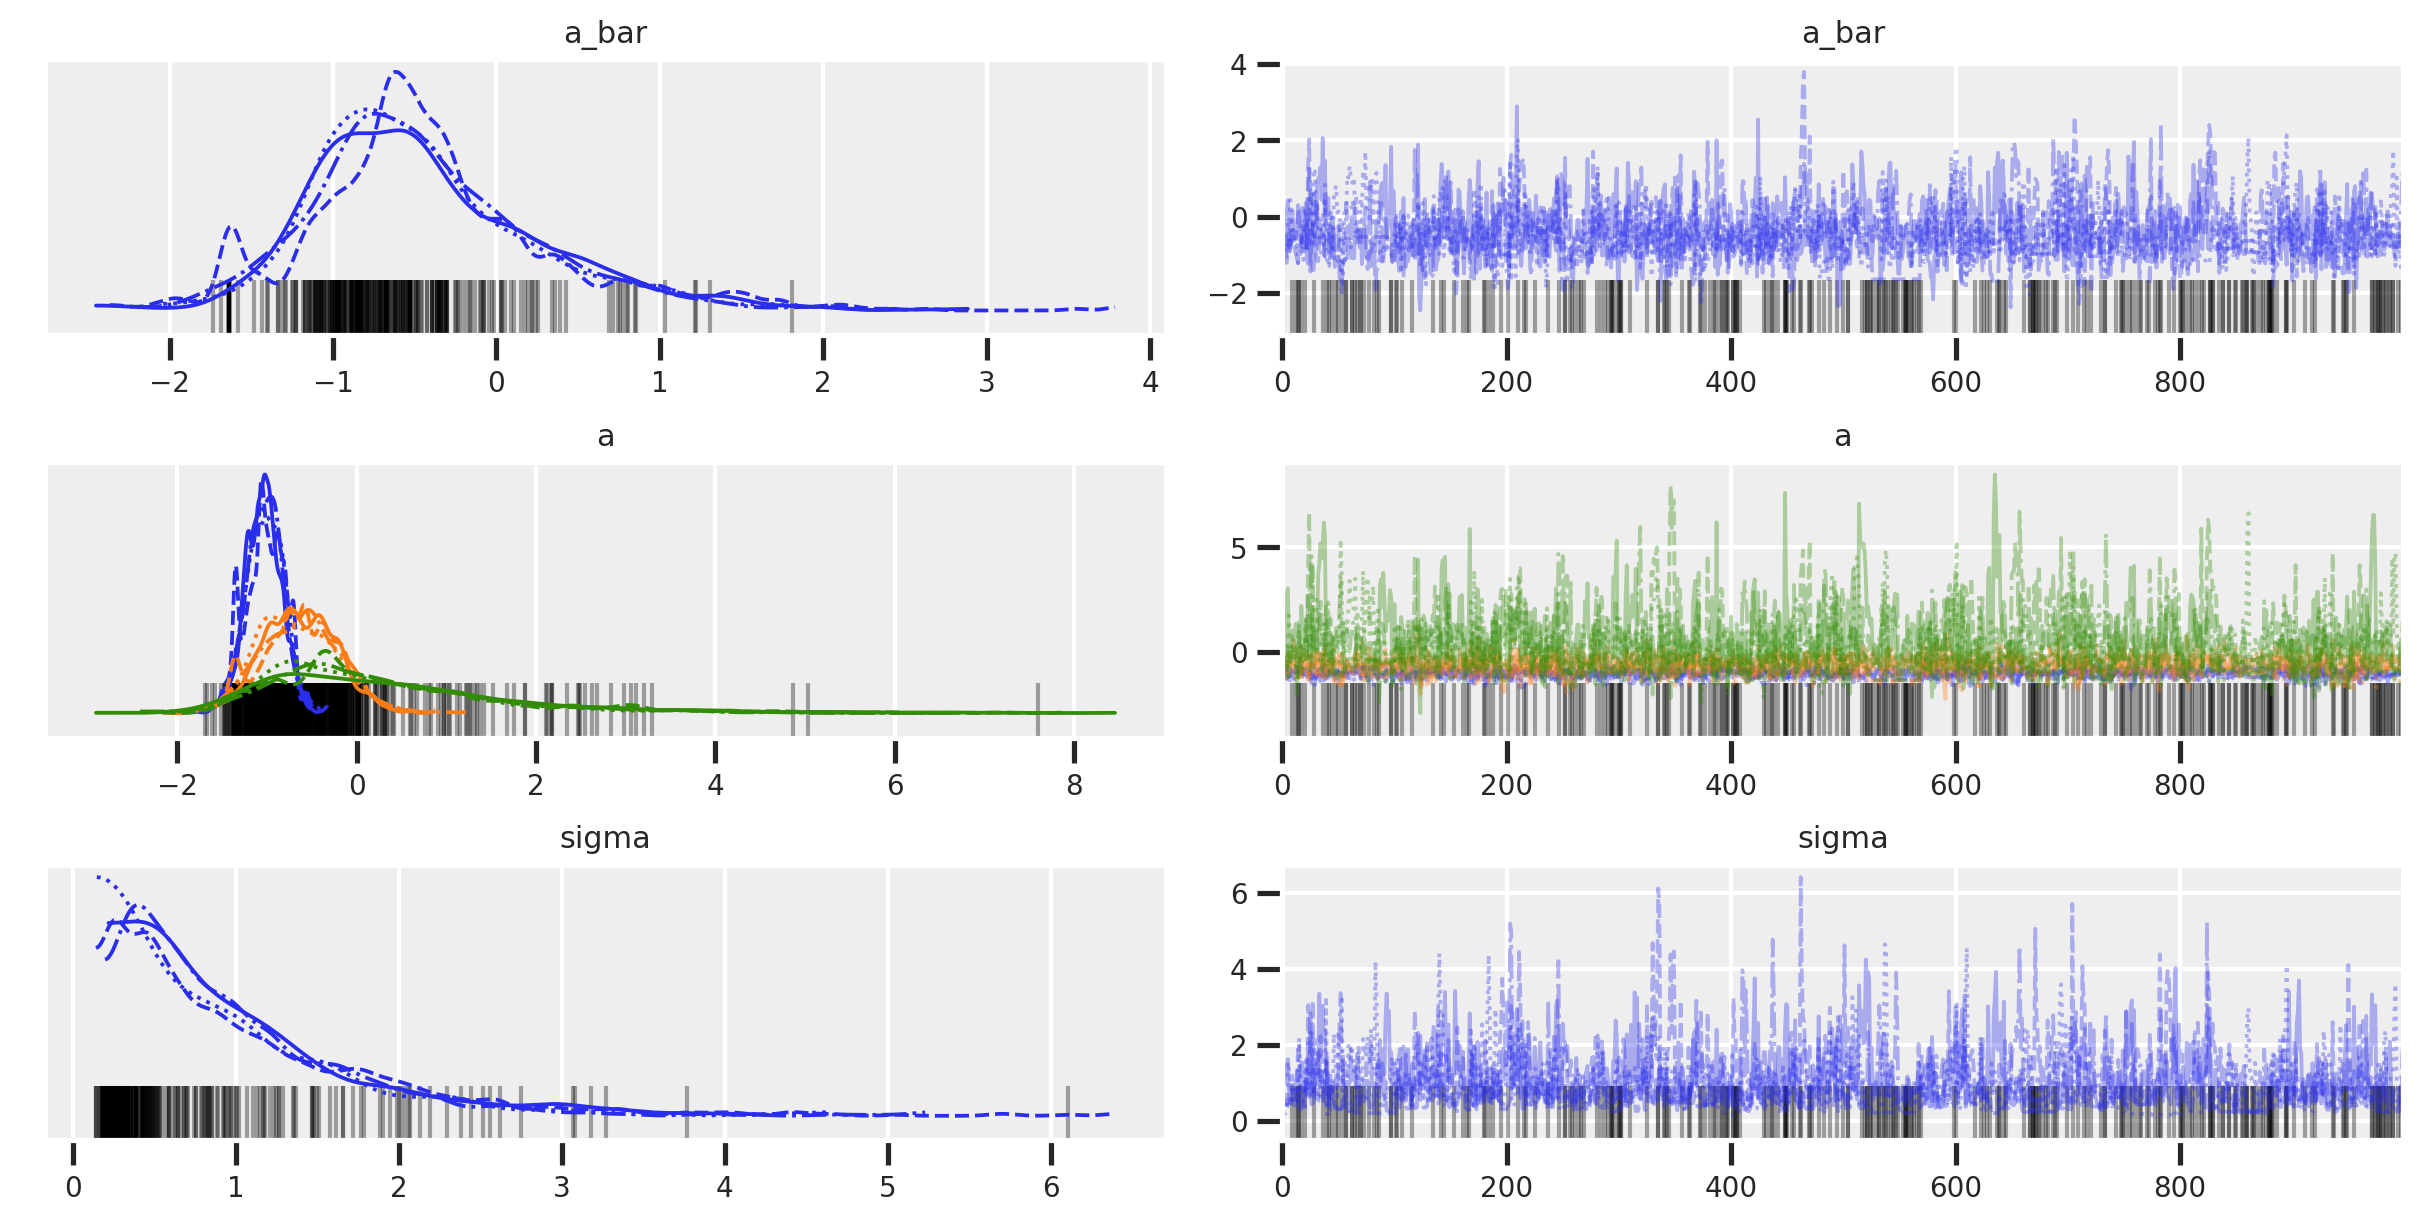

<IPython.core.display.Javascript object>

In [15]:
az.plot_trace(trace_mme0)

array([[<AxesSubplot:title={'center':'a_bar'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'a\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'a\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'a\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:>]], dtype=object)

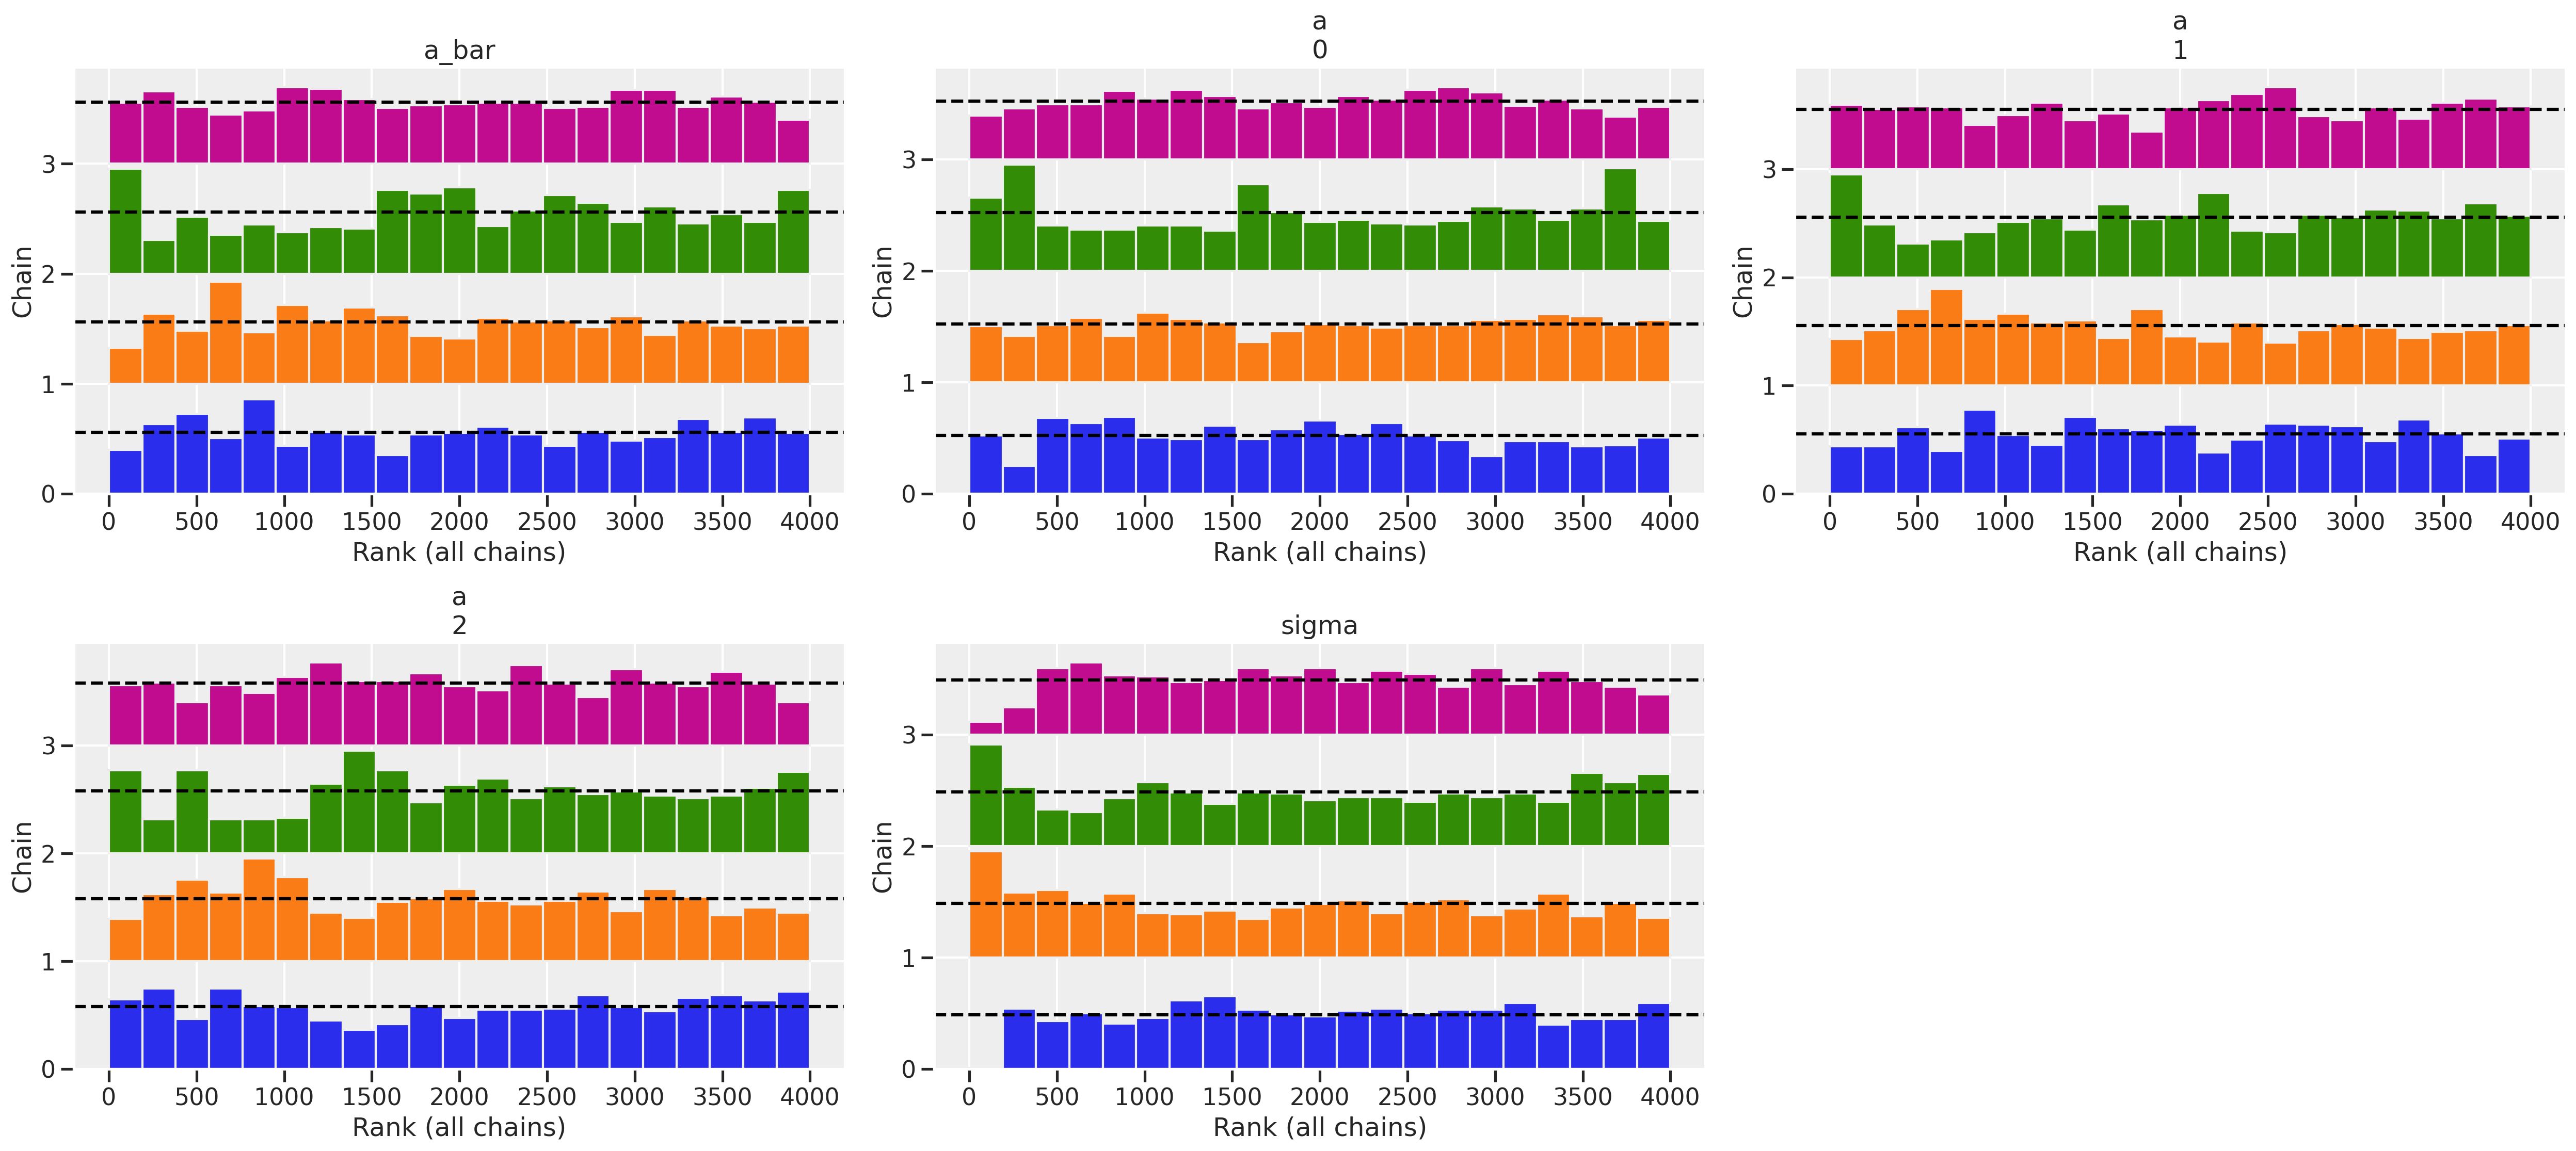

<IPython.core.display.Javascript object>

In [16]:
az.plot_rank(trace_mme0)

The `r_hat` seems to indicate that the chains didn't have a lot of variation between each other. But another thing to look at is the `ess_mean` which is an indicator of the effective sample size. A higher number means sampling the posterior distribution is more efficient. When we compare between the fixed effects and this first version of our mixed effects model, we can see that the latter had trouble sampling. The number of effective samples in the mixed effects model is much smaller for each district than in the fixed effects model. The trank plots are sounding alarms, particularly with the `sigma` parameter, but let's come back to this.

Text(0, 0.5, 'effective sample size (mean)')

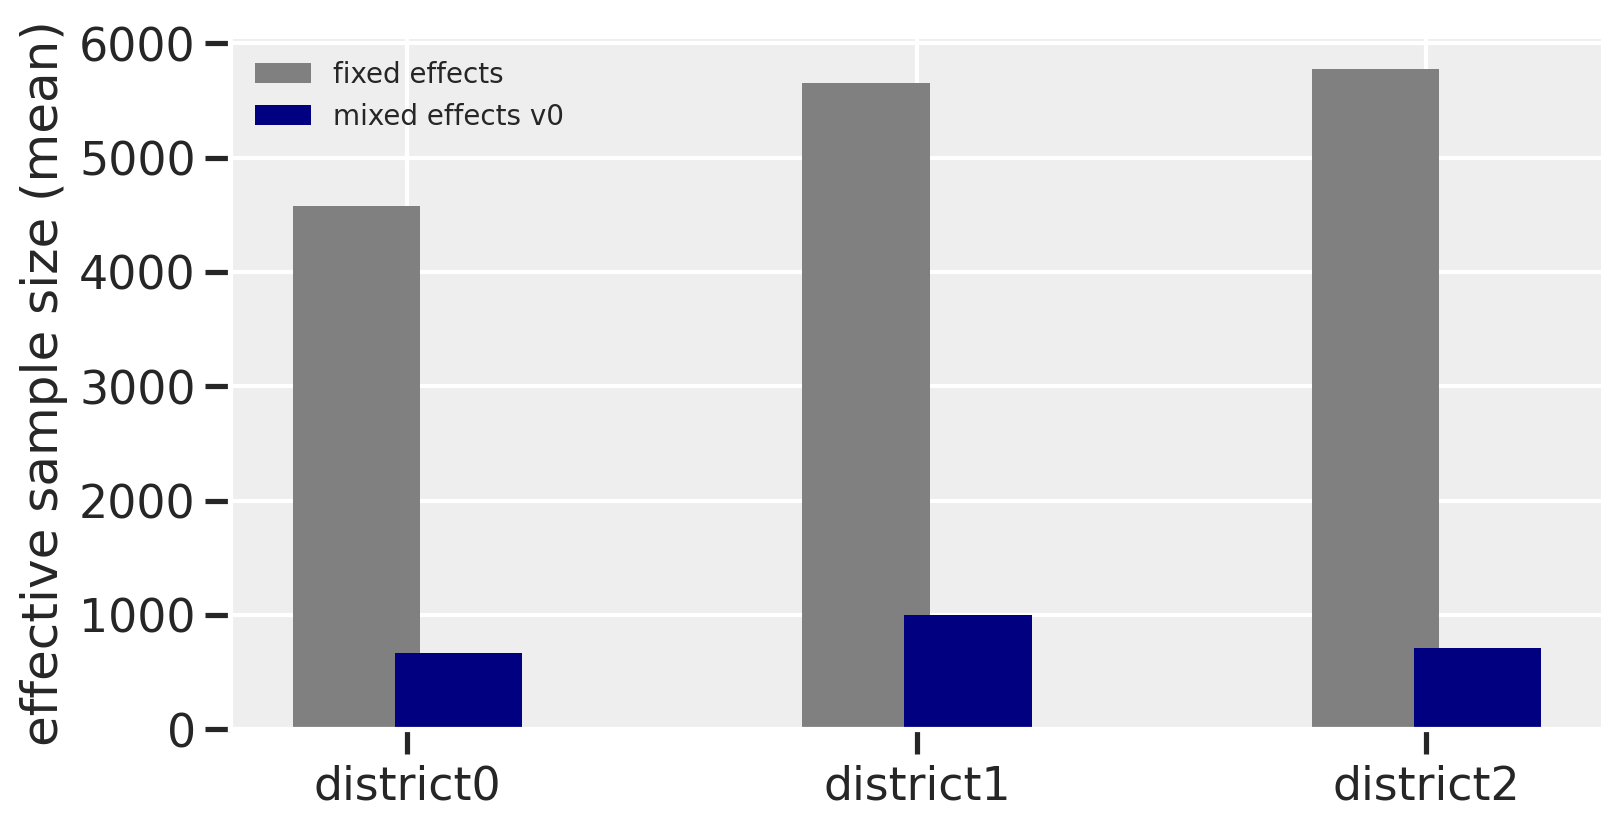

<IPython.core.display.Javascript object>

In [17]:
f, ax = plt.subplots(figsize=(8, 4))
ax.bar(x=[i - 0.1 for i in range(3)], height=az.summary(trace_mfe)['ess_mean'], width=0.25, color='gray', label='fixed effects')
ax.bar(x=[i + 0.1 for i in range(3)], height=az.summary(trace_mme0)['ess_mean'].iloc[1:4], width=0.25, color='navy', label='mixed effects v0')
ax.set_xticks(range(3))
ax.set_xticklabels(['district' + str(i) for i in range(3)])
ax.legend(fontsize=10)
ax.set_ylabel('effective sample size (mean)')

Let's now take a closer look at some of the warnings.

`There were 71 divergences after tuning.` This is an indication that the model had exploring all of the posterior distribution and that there could be a problem with the chains. Divergences result when the "energy at the start of the trajectory differs substantially from the energy at the end" according to pg. 278 of Statistical Rethinking. The energy pertains to the physics simulation that Hamiltonian Monte Carlo performs.

``Increase `target_accept` or reparameterize.`` This suggestion follows the above warning. We'll talk about reparamaterization later, but what is `target_accept` for? Per [the pymc documentation](https://docs.pymc.io/en/stable/api/inference.html), this controls the step size of the physics simulation. A higher `target_accept` value will lead to smaller step sizes, or a smaller duration of time to run each segment of a simulation. This will help explore tricky and curvy parts of a posterior distribution where a smaller `target_accept` value might overshoot and miss exploring these areas. (Why would you want a smaller `target_accept` if you can get away with it? The model will sample more efficiently if the posterior is not problematic.) Therefore, increasing the `target_accept` paramaeter is an easy thing we can change so let's try this first. The default value is 0.8, so let's try 0.9

# ME attempt 1: higher `target_accept`

In [18]:
with pm.Model() as mme1:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha prior, we only have 1 district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mme1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5782174075147031, but should be close to 0.9. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8194929209484552, but should be close to 0.9. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The 

<IPython.core.display.Javascript object>

In [19]:
az.summary(trace_mme1)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar -0.497  0.650    -1.371      0.559      0.024    0.017     720.0   
a[0]  -1.010  0.208    -1.332     -0.685      0.009    0.007     495.0   
a[1]  -0.652  0.405    -1.273      0.029      0.011    0.008    1290.0   
a[2]   0.193  1.327    -1.449      2.039      0.066    0.047     407.0   
sigma  0.866  0.741     0.091      1.765      0.051    0.036     214.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar   720.0     647.0     636.0   1.01  
a[0]    463.0     544.0    1926.0   1.01  
a[1]   1290.0    1198.0    1199.0   1.05  
a[2]    407.0     369.0    1246.0   1.02  
sigma   214.0      42.0      21.0   1.07

<IPython.core.display.Javascript object>

We get higher `ess_mean` values but our `r_hat` actually got worse. Looks like we have more work to do. But let's try `target_accept` again by [cranking it up](https://media.giphy.com/media/bHG5gzKfPESAGr4Dxg/giphy.gif) to 0.99

# ME attempt 2: even higher `target_accept`

In [20]:
with pm.Model() as mme2:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha prior, we only have 1 district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mme2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9658147278026631, but should be close to 0.99. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [22]:
az.summary(trace_mme2)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar -0.497  0.669    -1.382      0.558      0.022    0.016     913.0   
a[0]  -1.015  0.209    -1.327     -0.664      0.006    0.004    1358.0   
a[1]  -0.684  0.406    -1.355     -0.065      0.011    0.008    1419.0   
a[2]   0.122  1.315    -1.444      1.987      0.054    0.038     603.0   
sigma  0.865  0.760     0.019      1.749      0.034    0.024     489.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar   913.0     942.0    1475.0   1.00  
a[0]   1358.0    1352.0    1871.0   1.00  
a[1]   1419.0    1389.0    1621.0   1.00  
a[2]    603.0     709.0    1132.0   1.00  
sigma   489.0     349.0     425.0   1.01

<IPython.core.display.Javascript object>

These numbers look better, but the suggestions to reparamaterize persist. This problem we're observing is a a good example of [the folk theorem of statistical computing](https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/) and why we should make the effort to reparamaterize. But first, let's see if we can visualize this problematic posterior using the arviz `plot_pair` function.

## Visualizing divergent transitions

array([[<AxesSubplot:ylabel='a\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='a\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='a\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='a_bar', ylabel='sigma'>,
        <AxesSubplot:xlabel='a\n0'>, <AxesSubplot:xlabel='a\n1'>,
        <AxesSubplot:xlabel='a\n2'>]], dtype=object)

<Figure size 800x600 with 0 Axes>

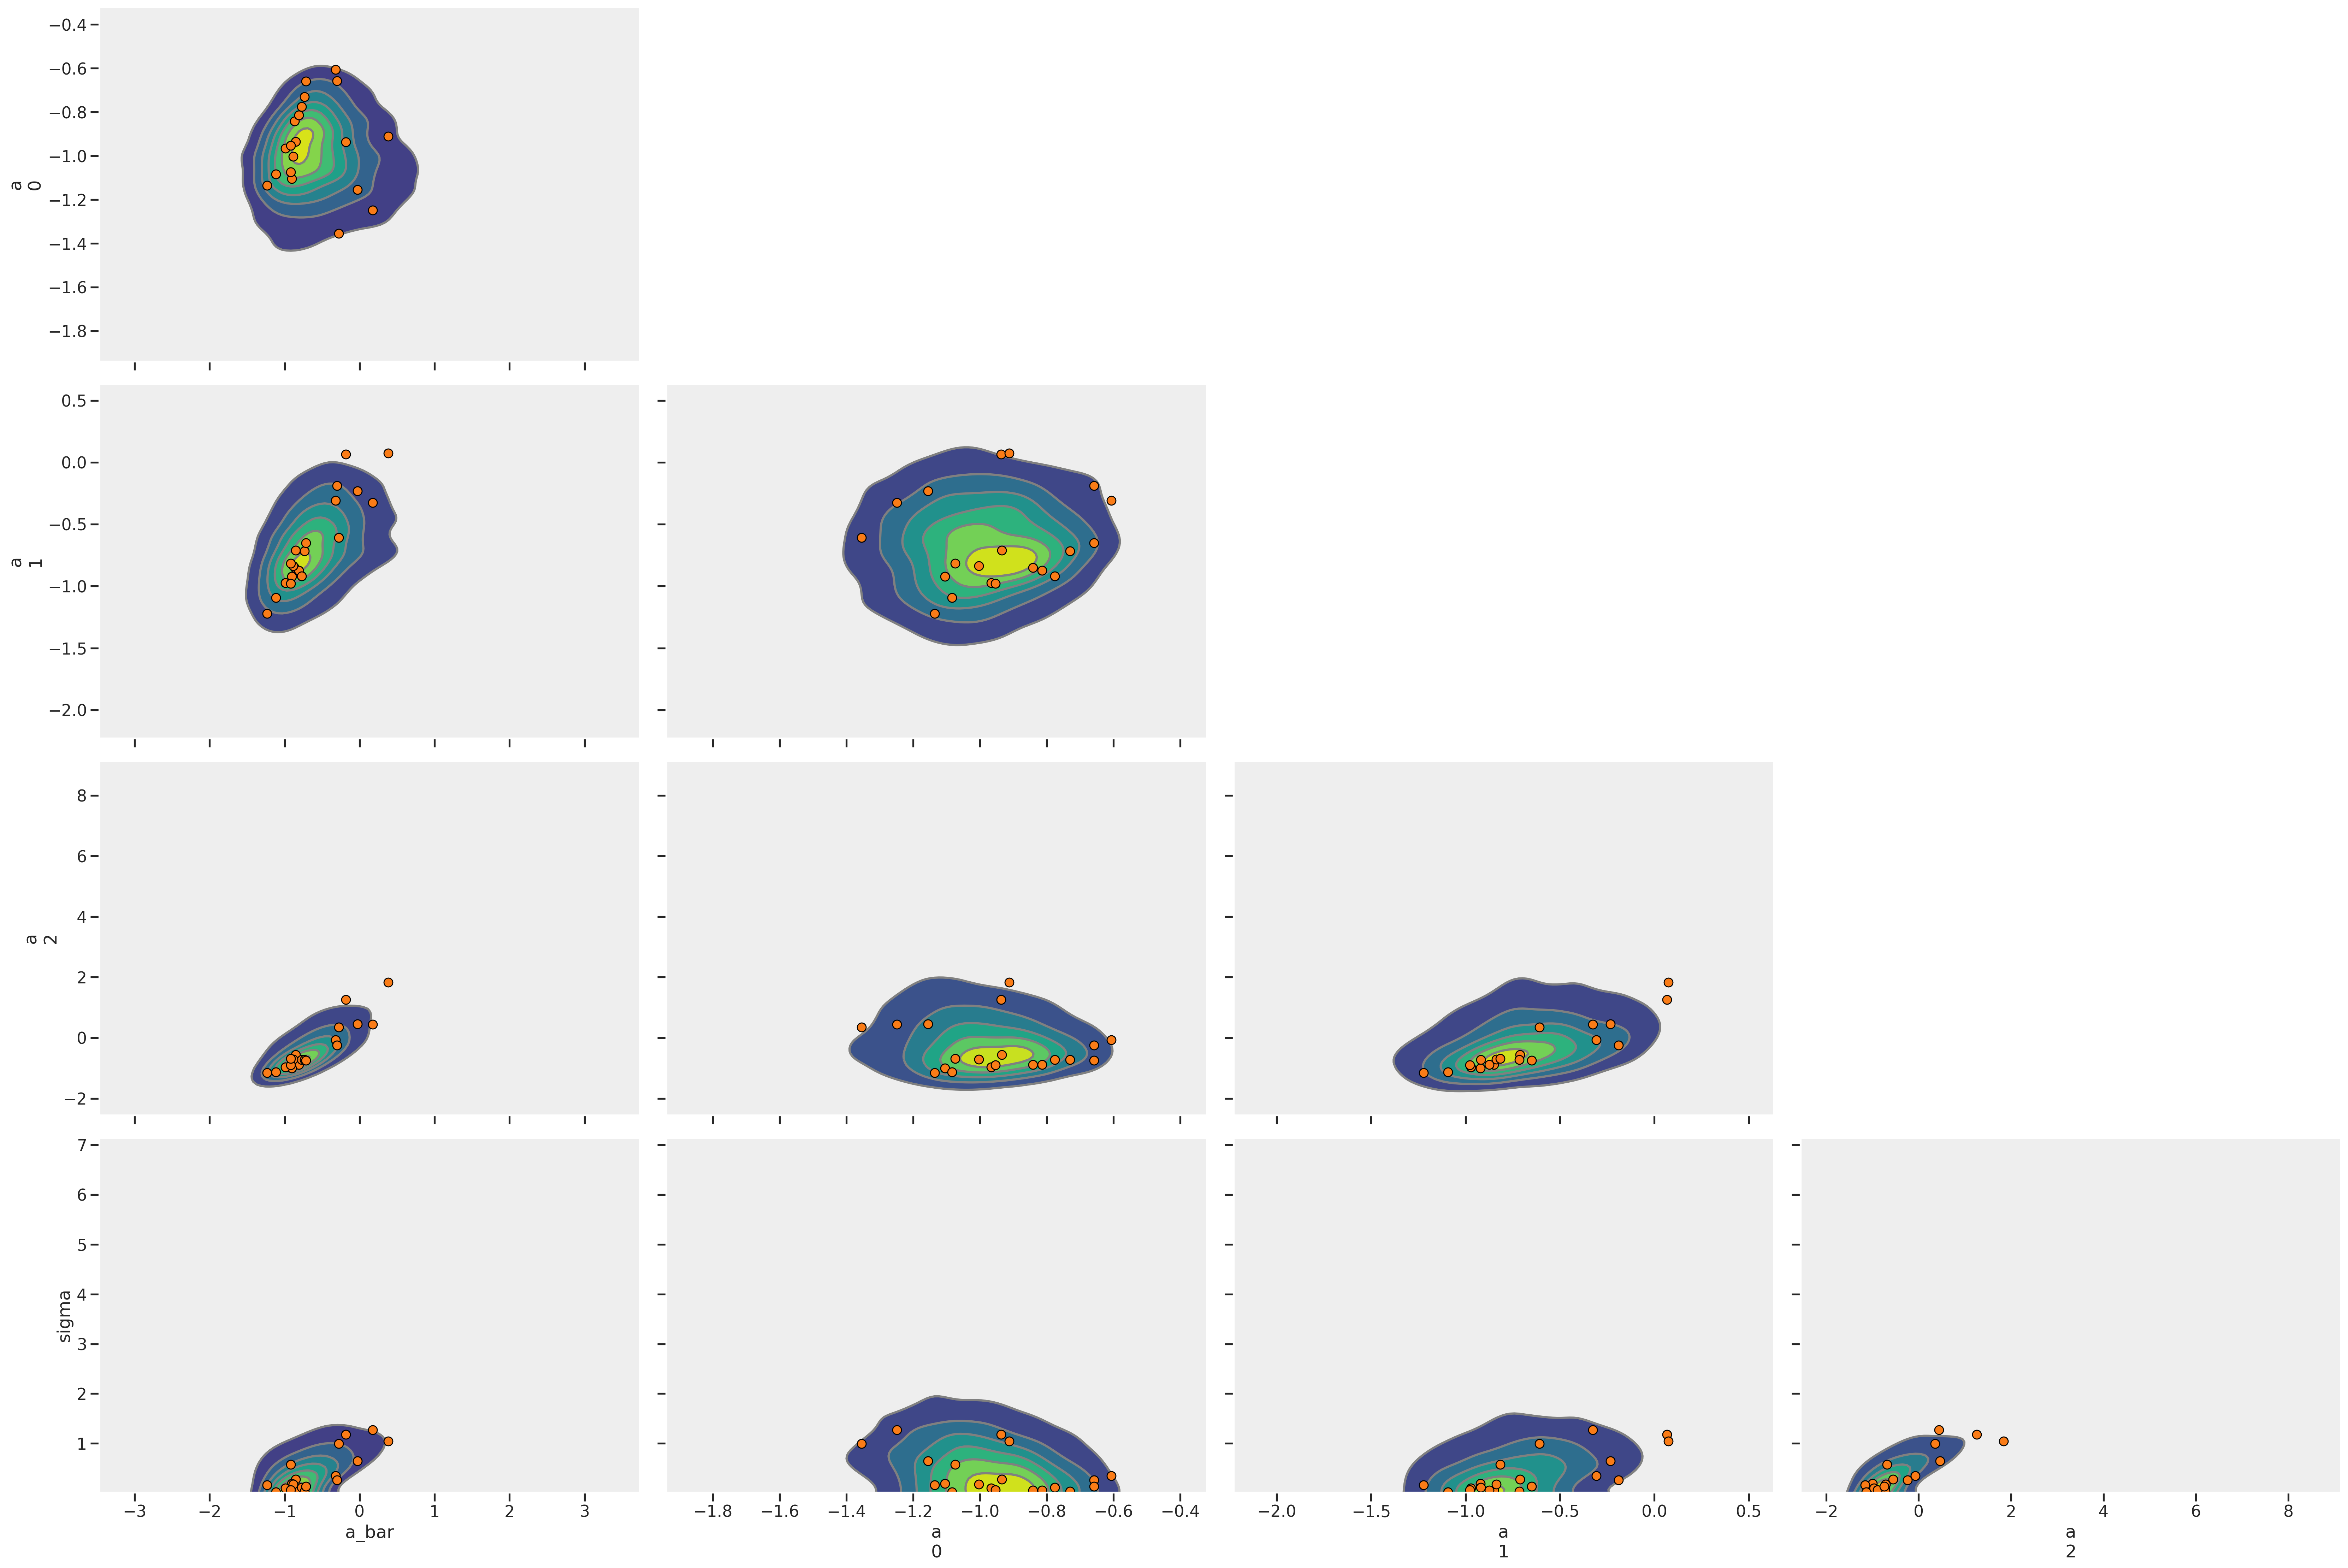

<IPython.core.display.Javascript object>

In [23]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
az.plot_pair(trace_mme2, kind='kde', divergences=True)

That's a lot of red dots! Each represents a divergent transition. Why could this happen? McElreath again provides a clue by pointing to the sigma parameter. When using a logit function "floor and ceiling effects sometimes render extreme values of the variance equally plausible as more realistic values." Let's look closer at some of the diagnostic metrics.

First we see low `ess_mean` and an `r_hat` is above 1.00, even if barely.

In [27]:
az.summary(trace_mme0, var_names='sigma')

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
sigma  0.966  0.752     0.167      1.885      0.033    0.023     523.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
sigma   523.0     232.0     134.0   1.01

<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

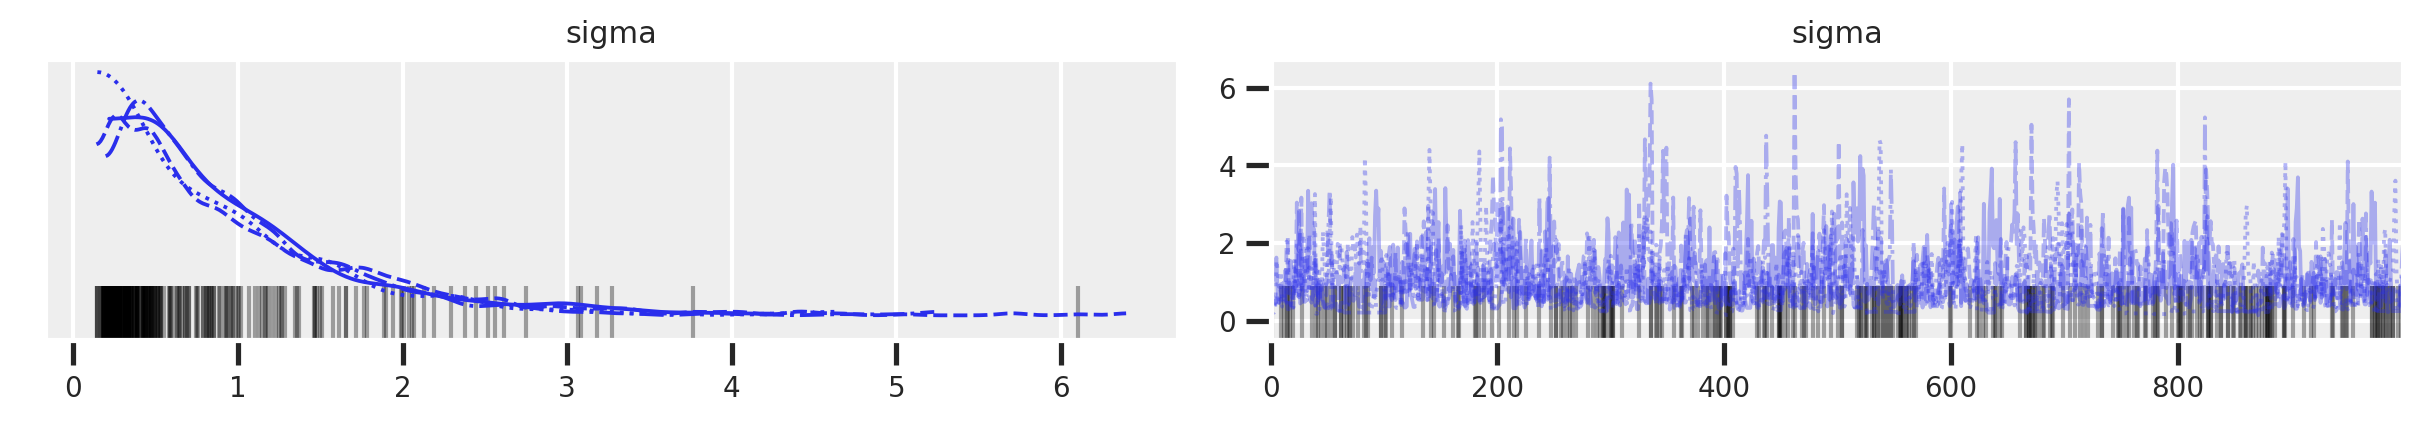

<IPython.core.display.Javascript object>

In [28]:
az.plot_trace(trace_mme0, var_names='sigma')

It's hard to tell what's going on in the trace plot, but the rank plot definitely indicates something strange is going on.

<AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>

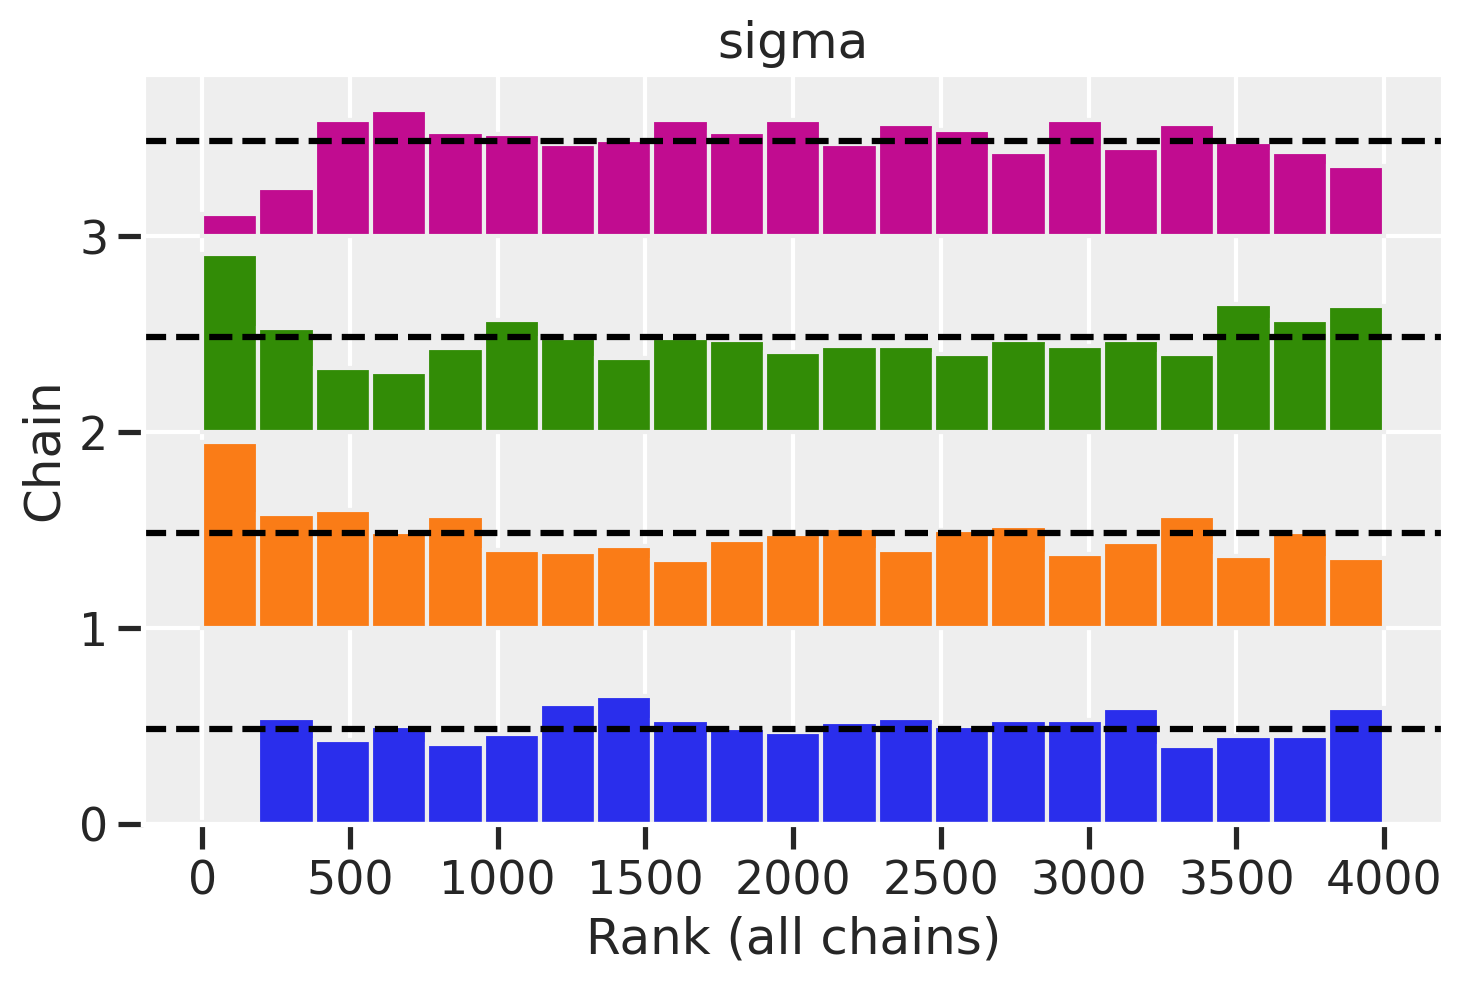

<IPython.core.display.Javascript object>

In [29]:
az.plot_rank(trace_mme0, var_names='sigma')

There's something simple we can do first to help avoid extreme values of variance: use a much more informative prior. Let's use a half-normal prior instead of an exponential. It will keep values of `sigma` positive while avoiding the more extreme values that a exponential distribution allows.

# ME attempt 3: more informative prior for sigma

**Plot exponential and half-normal (change these)**

[Text(0.5, 1.0, 'prior for $\\sigma$'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'density')]

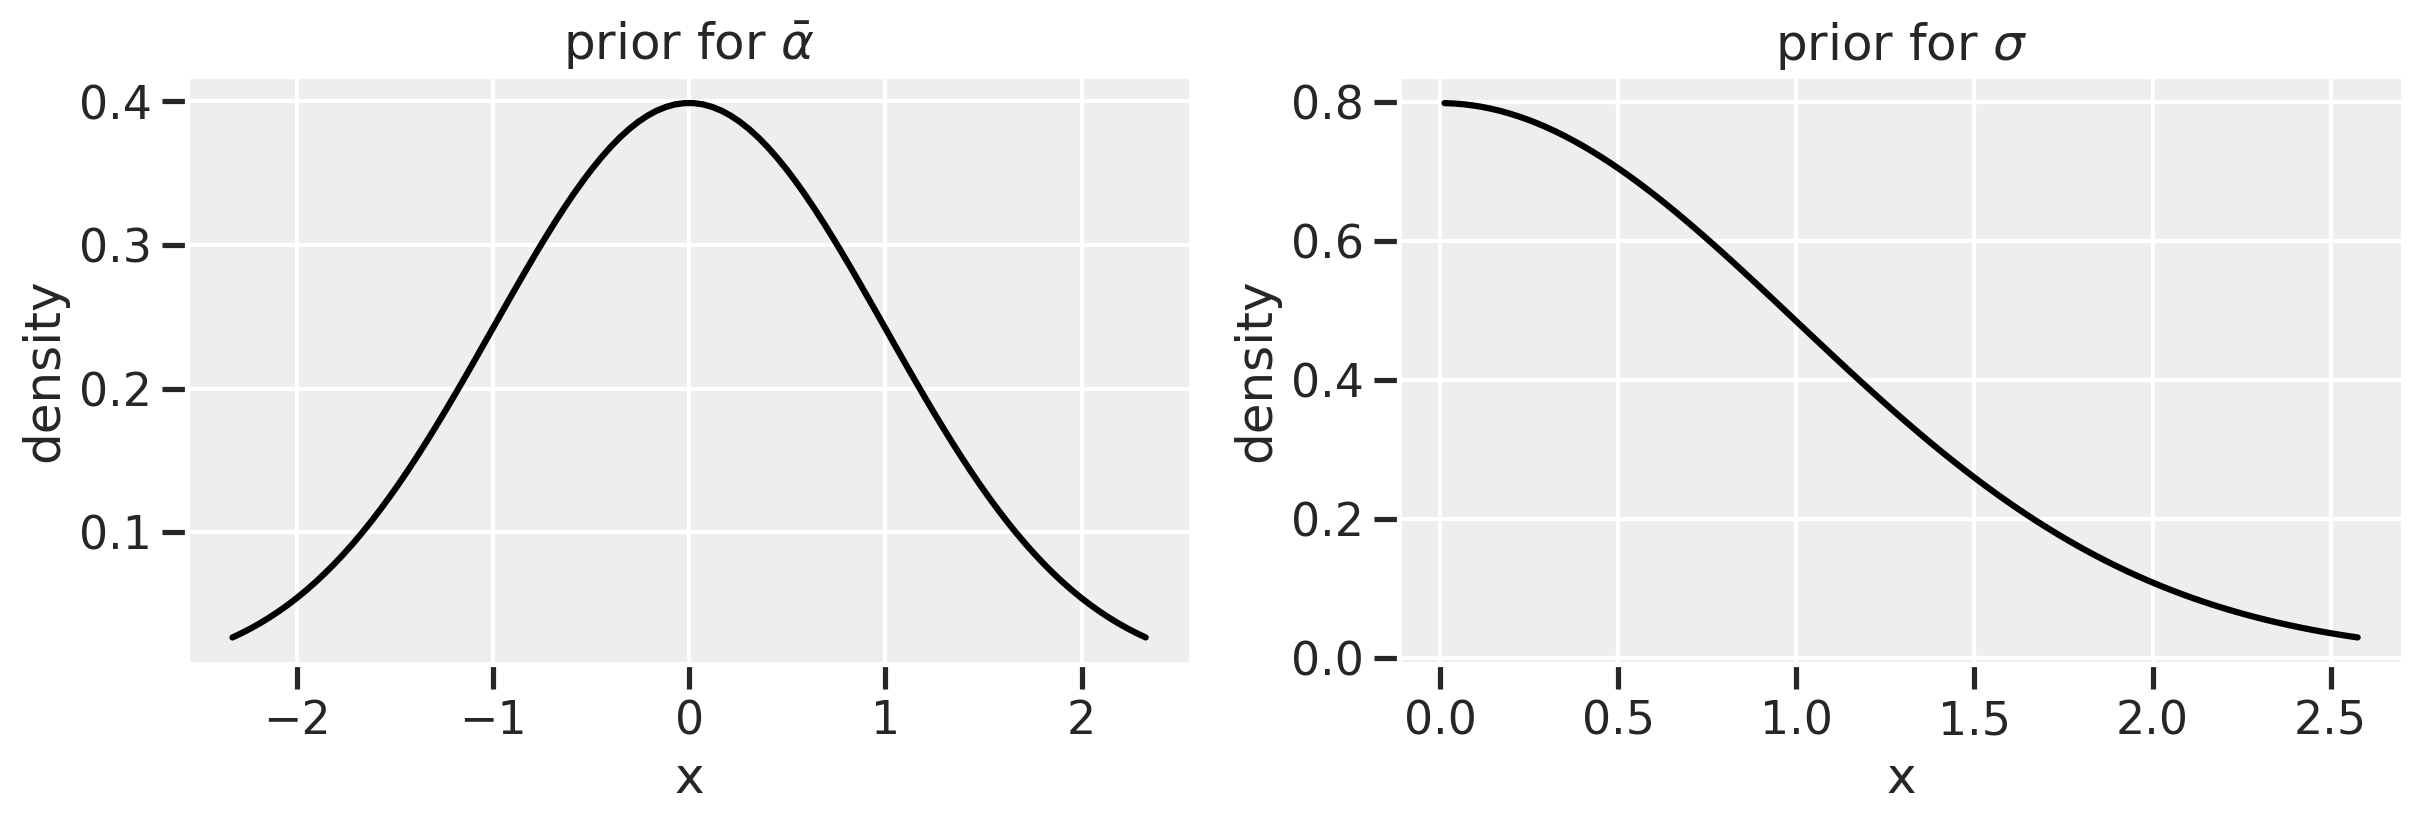

<IPython.core.display.Javascript object>

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# First two subplots ------------------------------------------
x1 = np.linspace(stats.norm.ppf(0.01),
                stats.norm.ppf(0.99), 100)
                
x2 = np.linspace(stats.halfnorm.ppf(0.01),
                stats.halfnorm.ppf(0.99), 100)

ax1.plot(x1, stats.norm.pdf(x1), color='black')
ax1.set(title=r'prior for $\bar{\alpha}$', xlabel = 'x', ylabel='density')
ax2.plot(x2, stats.halfnorm.pdf(x2), color='black')
ax2.set(title=r'prior for $\sigma$', xlabel = 'x', ylabel='density')


Model `mme3` equation

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{Half-Normal}(\text{TBD}) \tag{regularizing hyperprior}$$

I'm going to leave the exact value of our half-normal parameter TBD because I really don't know what's going to work. [We'll just have to try](https://media.giphy.com/media/3o7TKCFii3mAz693Ko/giphy.gif).

In [31]:
with pm.Model() as mme3:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.HalfNormal("sigma", 0.25)

    # alpha prior, we only have 1 district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mme3 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6423494210597291, but should be close to 0.99. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

Hmmm... that looks worse. Let's make sigma tighter by setting the half-normal parameter to 0.1.

In [34]:
with pm.Model() as mme3b:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.HalfNormal("sigma", 0.1)

    # alpha prior, we only have 1 district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mme3b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [35]:
az.summary(trace_mme3b)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar -0.924  0.205    -1.244     -0.597      0.009    0.006     571.0   
a[0]  -0.952  0.186    -1.260     -0.661      0.007    0.005     640.0   
a[1]  -0.917  0.220    -1.244     -0.557      0.009    0.007     600.0   
a[2]  -0.911  0.230    -1.269     -0.548      0.010    0.007     585.0   
sigma  0.081  0.059     0.004      0.161      0.003    0.002     346.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar   542.0     573.0     517.0   1.00  
a[0]    613.0     650.0     662.0   1.00  
a[1]    567.0     601.0     608.0   1.00  
a[2]    567.0     578.0     649.0   1.00  
sigma   346.0     286.0     532.0   1.02

<IPython.core.display.Javascript object>

# ME, attempt 4: re-paramaterization

Our `r_hat` for the `a` values are better, but the `ess_mean` indicates some ineffiencies still. The `sigma` also still looks bad. Now we should really consider re-paramaterizing. Luckily, we have an example of how to do this in the book.

Let's look again at the original equation. We've got a substitution we can make for $\alpha$. We can also loosen the sigma back up, using a Half-Normal(0.5) prior.

Centered equation

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{Half-Normal}(\text{TBD}) \tag{regularizing hyperprior}$$


Non-centered equation

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \bar{\alpha} + z_{\text{district}[i]} \sigma \tag{substituting for alpha}$$

$$z \sim \text{Normal}(0, 1) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{Half-Normal}(0.5) \tag{regularizing hyperprior}$$

The non-centered equation gives us a posterior that is easier to explore, while allowing us to use transformations to get back the numerical values we care about.

In [157]:
with pm.Model() as mme4:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districs
    sigma = pm.HalfNormal("sigma", 0.5)

    # our substitution
    z = pm.Normal("z", 0.0, 1, shape=len(df_bangladesh_first3["district_code"].unique()))

    # alpha prior, we only have 1 district
    # a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a_bar + z[df_bangladesh_first3["district_code"]] * sigma)

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mme4 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False, target_accept=0.99)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
INFO:pymc3:NUTS: [z, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [158]:
az.summary(trace_mme4)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar -0.731  0.409    -1.343     -0.137      0.014    0.010     905.0   
z[0]  -0.513  0.883    -1.884      0.894      0.025    0.018    1238.0   
z[1]   0.059  0.870    -1.237      1.504      0.019    0.015    2150.0   
z[2]   0.453  1.002    -1.138      2.039      0.021    0.016    2334.0   
sigma  0.393  0.290     0.000      0.783      0.008    0.006    1216.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar   905.0    1116.0    1060.0    1.0  
z[0]   1238.0    1245.0    1783.0    1.0  
z[1]   1661.0    2138.0    2537.0    1.0  
z[2]   1919.0    2332.0    2212.0    1.0  
sigma  1216.0    1037.0    1015.0    1.0

<IPython.core.display.Javascript object>

Hallelujah! We've got no divergences, a great `ess_mean` and `r_hat` values. Let's visualize what we've got.

array([[<AxesSubplot:ylabel='z\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='z\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='z\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='a_bar', ylabel='sigma'>,
        <AxesSubplot:xlabel='z\n0'>, <AxesSubplot:xlabel='z\n1'>,
        <AxesSubplot:xlabel='z\n2'>]], dtype=object)

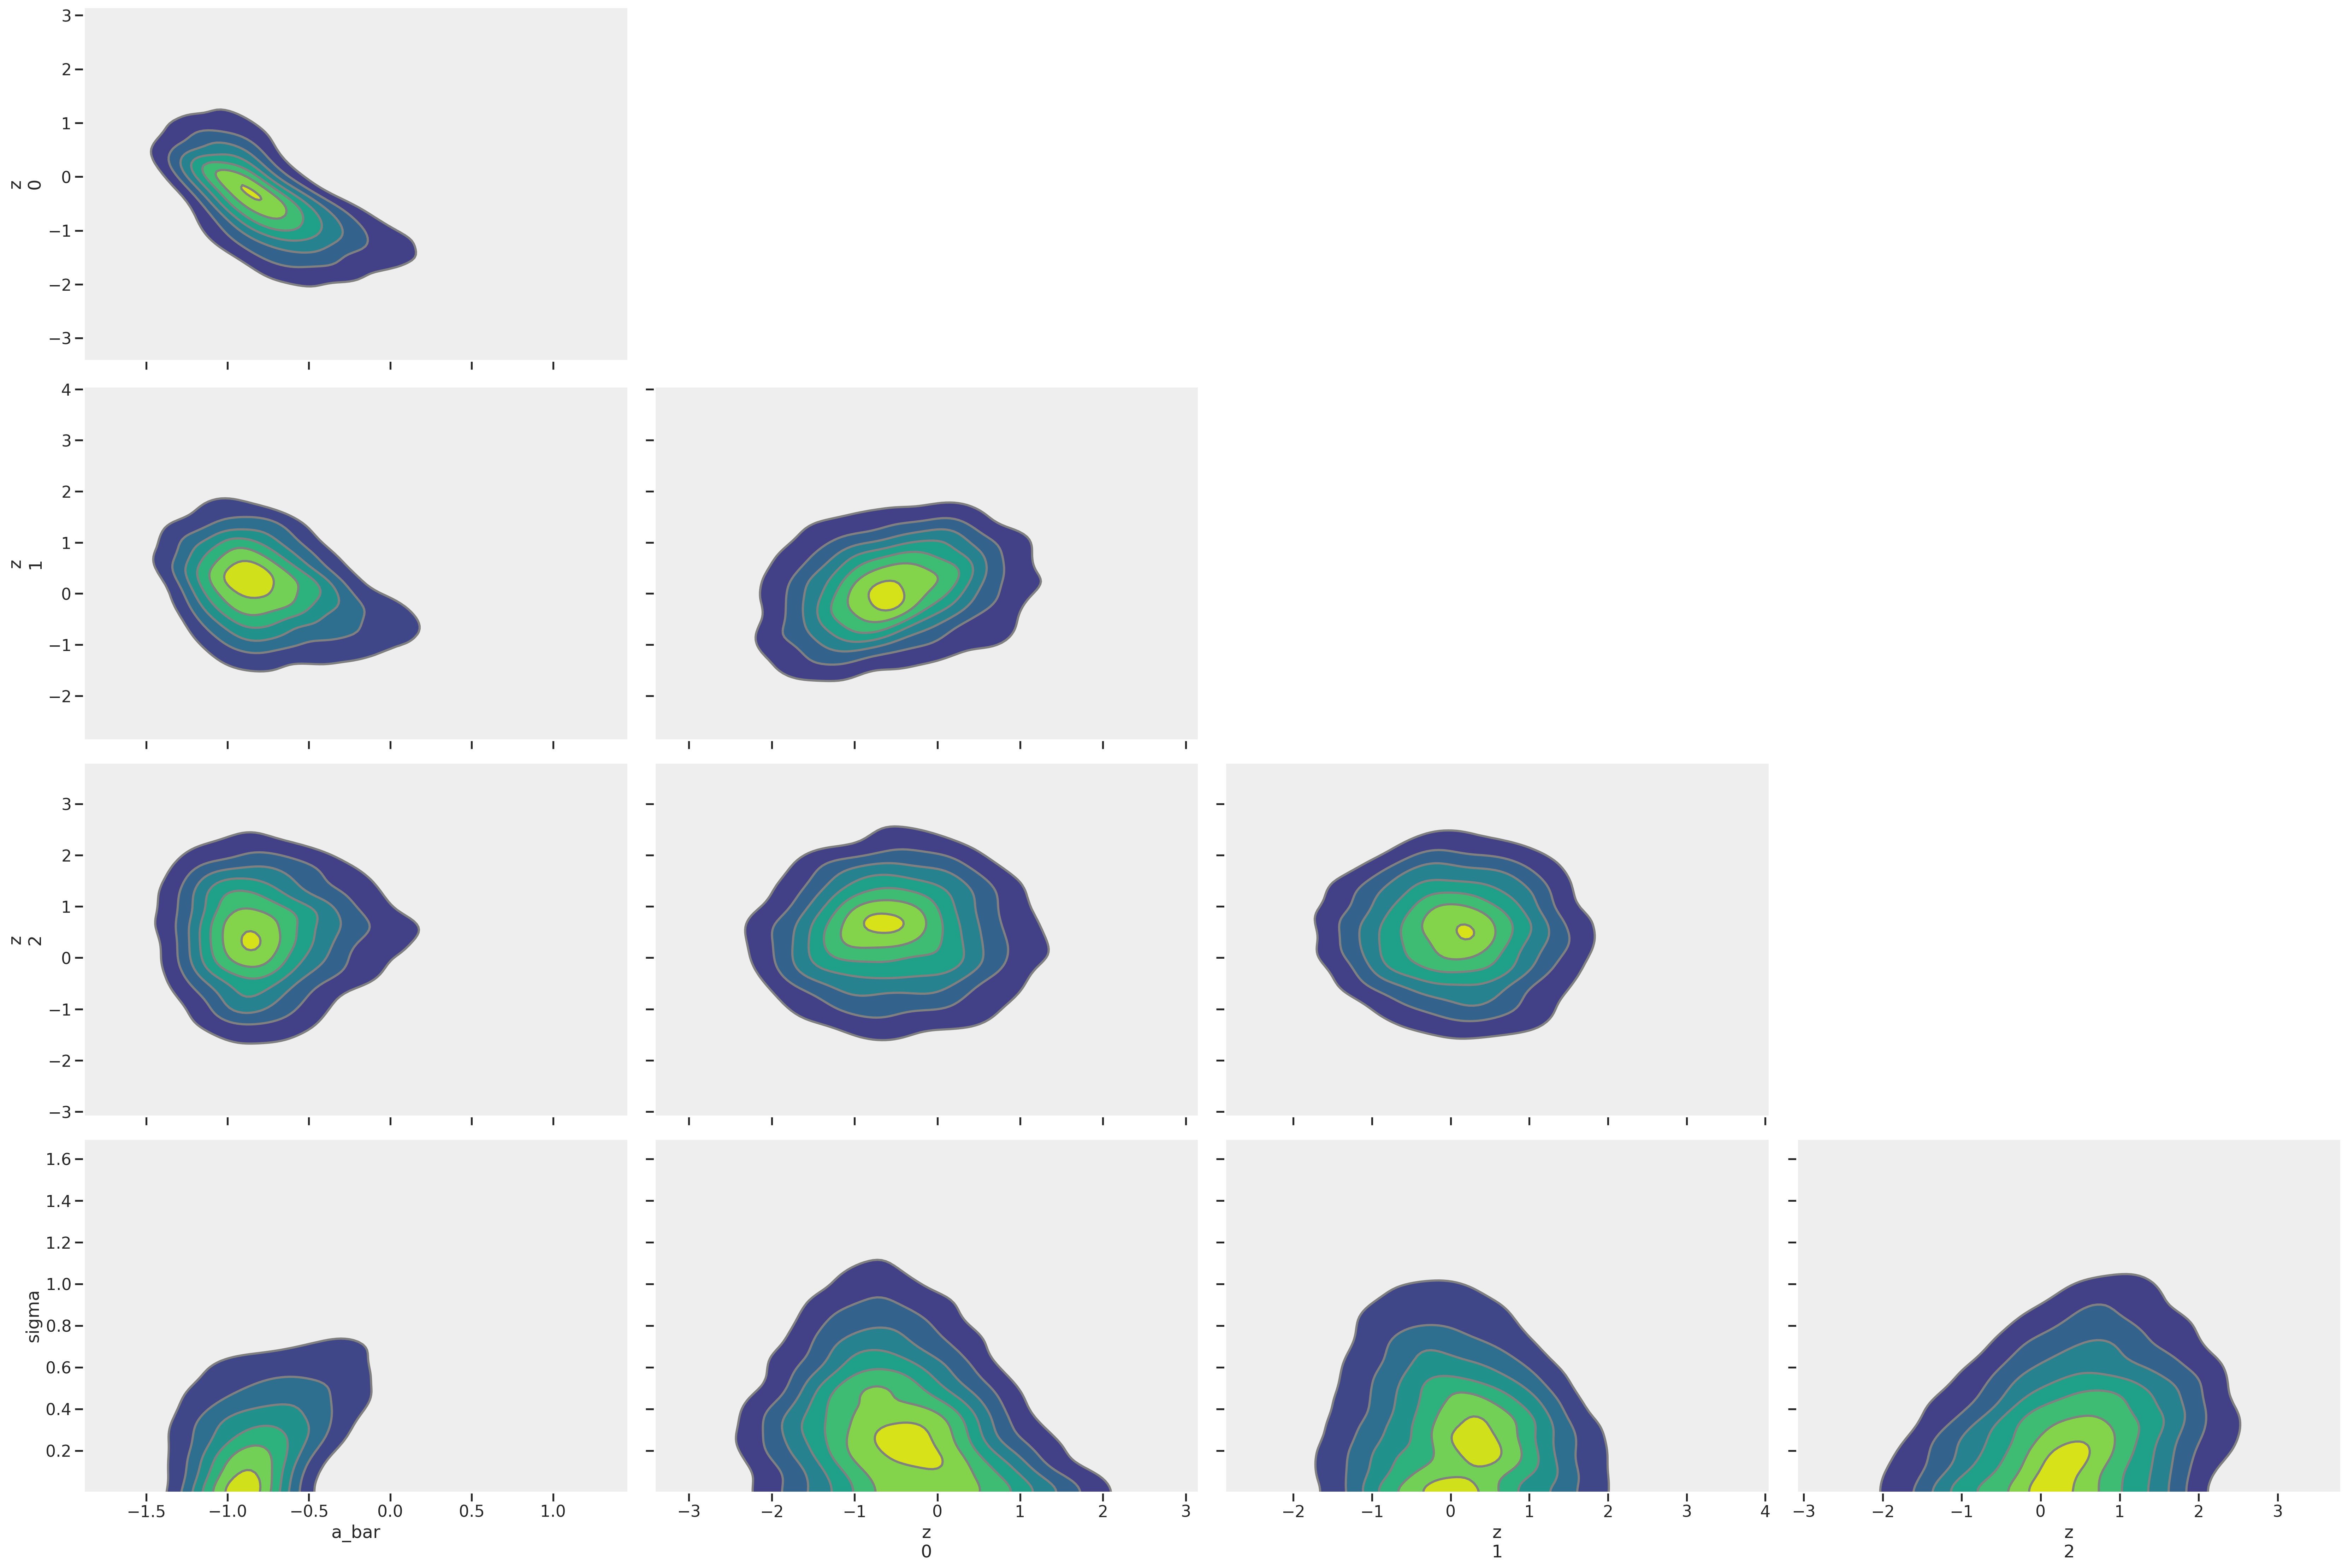

<IPython.core.display.Javascript object>

In [159]:
az.plot_pair(trace_mme4, kind='kde', divergences=True)

Clean pair plots!

<AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>

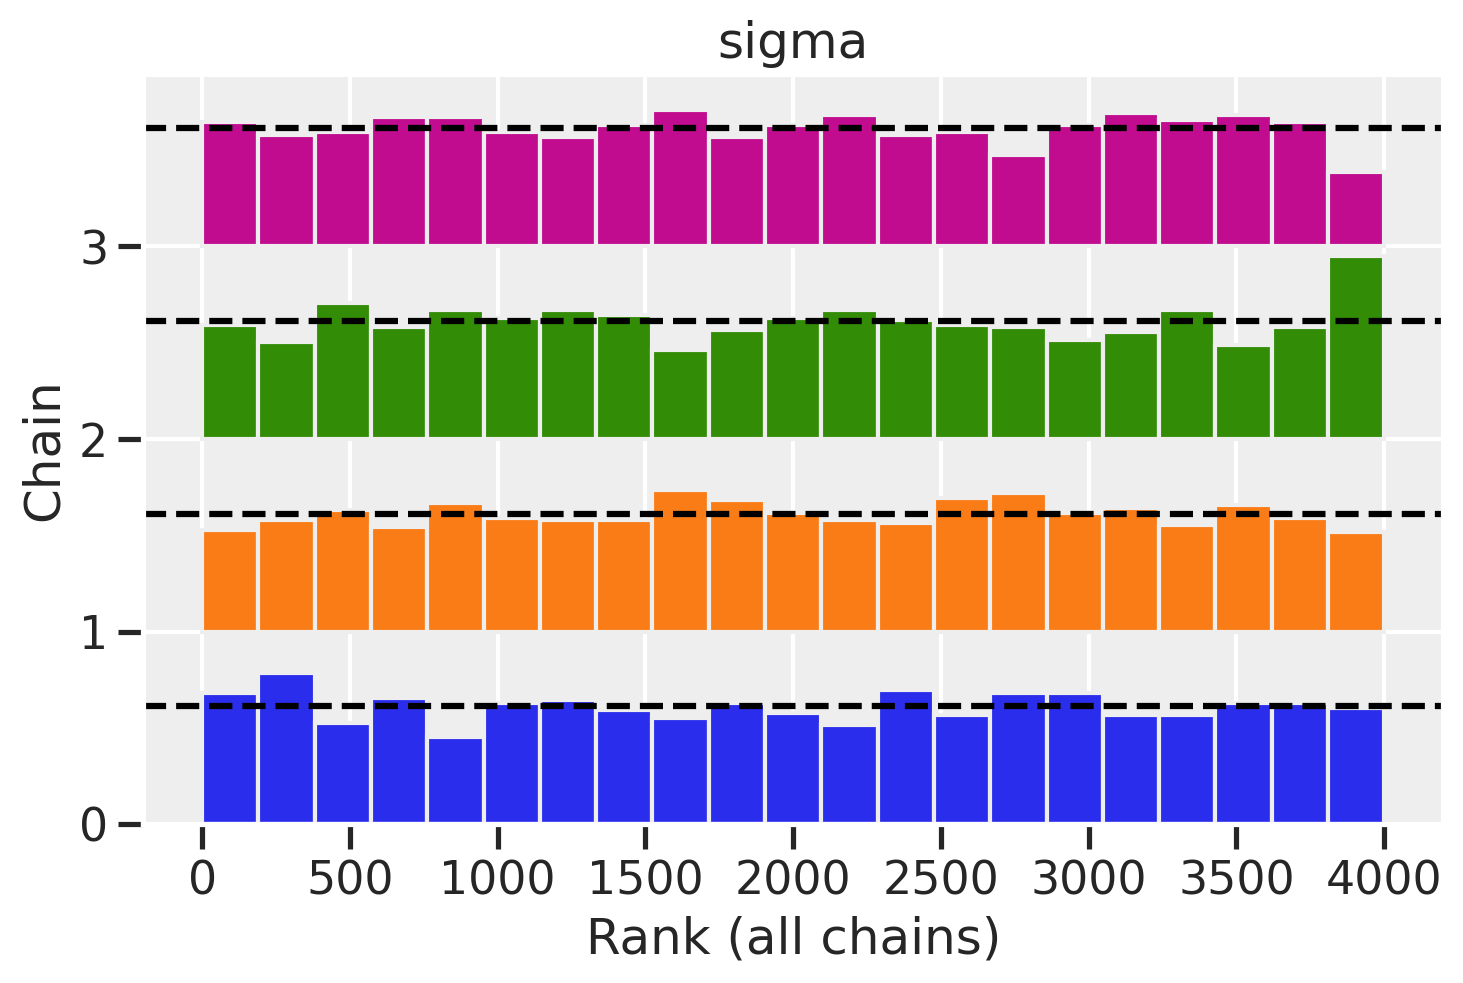

<IPython.core.display.Javascript object>

In [160]:
az.plot_rank(trace_mme4, var_names='sigma')

Great rank plots!

Now let's get our `a` values back. It might be a little tricky to see where this came from so let's review the most important parts of the centered and non-centered equations.

Centered equation
$$ \text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior} $$


Non-centered equation
$$ \text{logit}(p_i) = \bar{\alpha} + z_{\text{district}[i]} \sigma \tag{substituting for alpha} $$
$$ z \sim \text{Normal}(0, 1) \tag{adaptive prior} $$

$\alpha$ became $\bar{\alpha} + z_{\text{district}[i]} \sigma$.

In [161]:
trace_mme4_df = trace_mme4.to_dataframe()
trace_mme4_df.iloc[0:5, 0:7]

chain  draw  (posterior, a_bar)  (posterior, z[0], 0)  \
0      0     0            0.185127             -1.501203   
1      0     1           -0.025513             -1.515975   
2      0     2           -0.334302             -1.174676   
3      0     3           -0.134617             -2.165963   
4      0     4           -0.151168             -2.197087   

   (posterior, z[1], 1)  (posterior, z[2], 2)  (posterior, sigma)  
0             -0.768144              1.673570            0.547466  
1             -1.125922             -0.096766            0.684001  
2             -1.535301              0.709949            0.569022  
3             -1.432953              0.741756            0.376201  
4             -1.454579              0.214046            0.226324

<IPython.core.display.Javascript object>

Therefore, we can get `a` parameters for each district (`a[0], a[1], a[2]`) values by doing the appropriate arithmetic on each row. I'm going to ignore the chains for now.

In [162]:
# Initialize
df_a = pd.DataFrame(np.zeros((len(trace_mme4_df), 3)))

# Fill in rows with transformation
df_a[0] = trace_mme4_df[('posterior', 'a_bar')] + trace_mme4_df[('posterior', 'z[0]', 0)] * trace_mme4_df[('posterior', 'sigma')]
df_a[1] = trace_mme4_df[('posterior', 'a_bar')] + trace_mme4_df[('posterior', 'z[1]', 1)] * trace_mme4_df[('posterior', 'sigma')]
df_a[2] = trace_mme4_df[('posterior', 'a_bar')] + trace_mme4_df[('posterior', 'z[2]', 2)] * trace_mme4_df[('posterior', 'sigma')]

<IPython.core.display.Javascript object>

We can plot our parameters now, with a bit more plotting code for the middle plot since we have raw values. And just as a reminder of the original goal of the post, we'll show the fixed effects model as well. We'l plot them on the same x-scale to show the dramatic difference that partial pooling has.

Text(0.5, 1.0, 'a parameters\nfixed-effects')

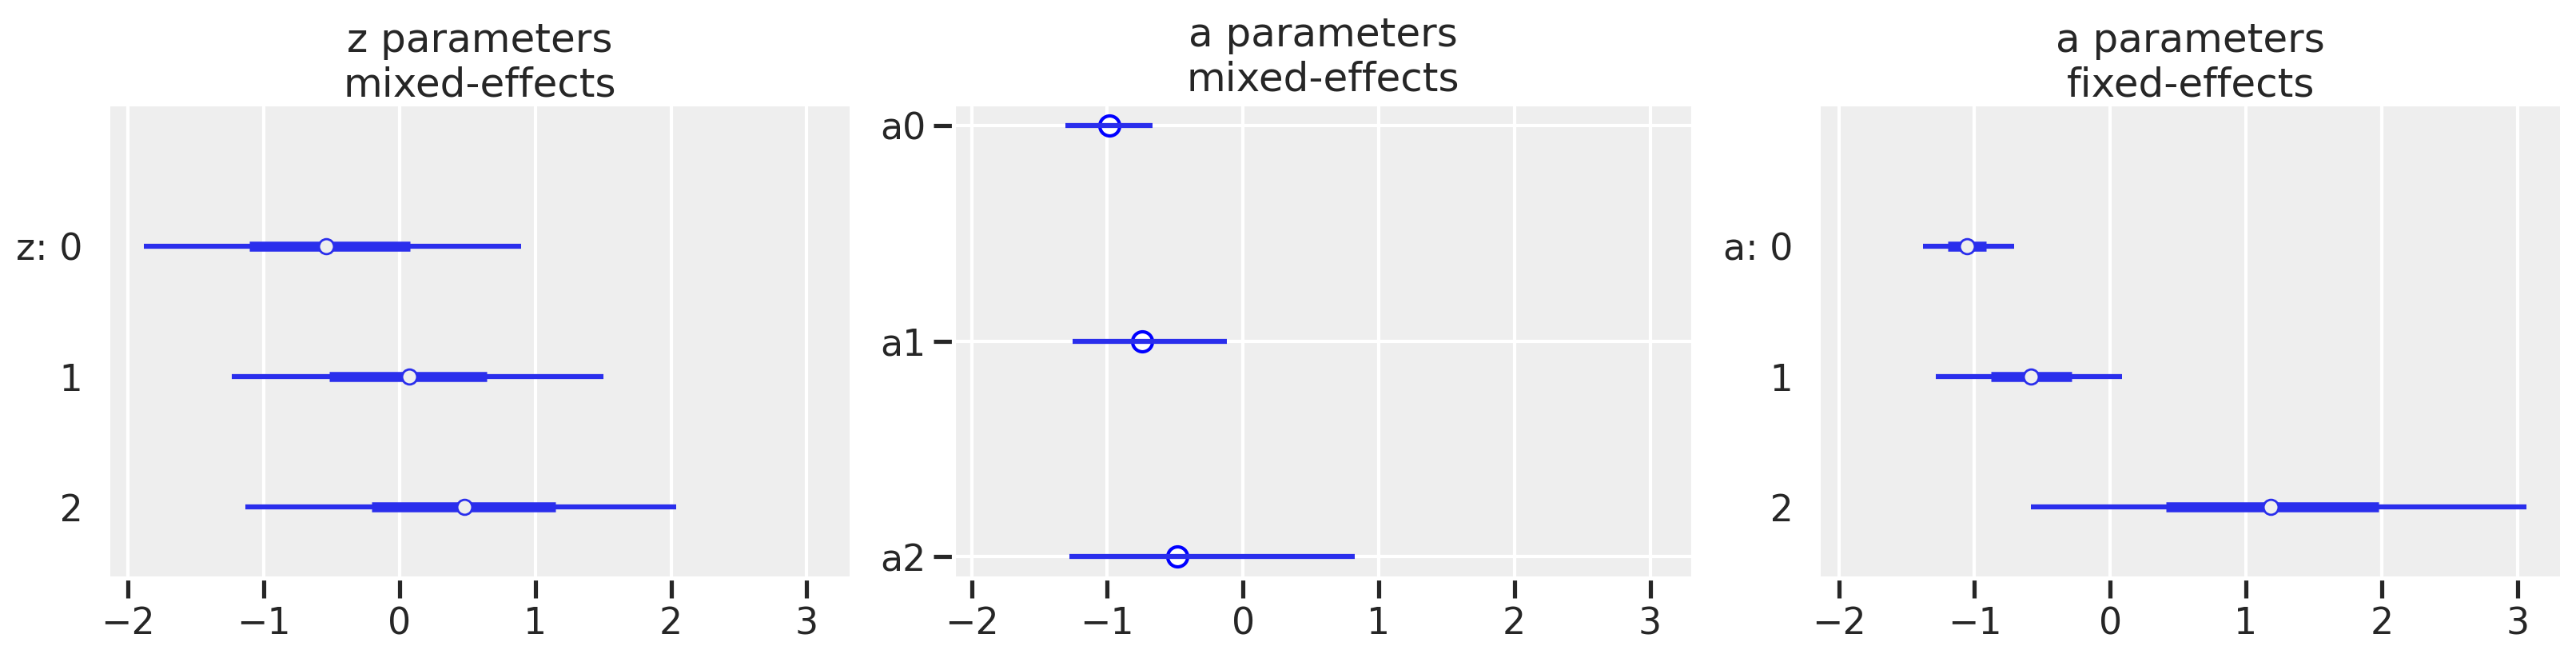

<IPython.core.display.Javascript object>

In [163]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
# z parameters, mixed effects
az.plot_forest(trace_mme4, var_names='z', combined=True, ax=ax1)
ax1.set_title("z parameters\nmixed-effects")

# a parameters, mixed effects
ax2.hlines(xmin=df_a[0].quantile(0.055), xmax=df_a[0].quantile(0.945), y=0)
ax2.hlines(xmin=df_a[1].quantile(0.055), xmax=df_a[1].quantile(0.945), y=1)
ax2.hlines(xmin=df_a[2].quantile(0.055), xmax=df_a[2].quantile(0.945), y=2)
ax2.scatter(df_a.mean(), range(3), facecolors='white', edgecolors='blue')
ax2.invert_yaxis()
ax2.set_yticks(range(3))
ax2.set_yticklabels(["a" + str(i) for i in range(3)])
ax2.set_title("a parameters\nmixed-effects")

# a parameters, fixed effects
az.plot_forest(trace_mfe, var_names='a', combined=True, ax=ax3)
ax3.set_title("a parameters\nfixed-effects")

In the mixed-effects model, we see that the point estimates of the `a` parameters mirror the pattern of the `z` parameters which is to be expected. Of course, after we have gone through our model diagnostics and iterations, the bigger picture is that the multi-level model has a much different result than the fixed-effects model which we created at the start of the post. We see shrinkage of our estimates so that it appears our districts have less of a difference among them than originally seen with the fixed-effects model. We also see a reduction in variance. Both the movement in the point estimate and reduction in variance are most dramatic for district 2 which has the smallest sample size of the three shown here.

# Summary

Well, what started as a simple post led to a deeper understanding of how to diagnose a model and what knobs to fiddle. More often than not, we'll have to turn to alternate paramaterizations as we did here. In another post, we'll get back to the original goal of understanding how partial pooling happens, resulting in shrinkage of estimates for our clusters.

Appendix: Environment and system parameters

In [134]:
%watermark -n -u -v -iv -w

Last updated: Mon Nov 22 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy     : 1.6.0
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pandas    : 1.2.1
seaborn   : 0.11.1
pymc3     : 3.11.0
numpy     : 1.20.1
theano    : 1.1.0
arviz     : 0.11.1
matplotlib: 3.3.4

Watermark: 2.1.0



<IPython.core.display.Javascript object>